In [2]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib

import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

import pytensor.tensor as pt

# Case Cohort - Simple Bernoulli
- STRONGLY BIASED

## DTST Generator

In [17]:
# np.random.seed(11)
N = 4000
x1 = np.concatenate([np.zeros(int(N*7/8)),np.ones(int(N*1/8))]) # 0,1 var (our condition)
x2 = np.random.normal(0,1, N) # continuous var
x = np.matrix([x1,x2]).T
# when x1 = 1 and x2 increases, the risk increases
z0 = -2 +2*x[:,0] + .5*x[:,1]
z0 = z0.reshape(N,1)
mu0 = sp.norm.cdf(z0).reshape(N,)

# get y
# y0 = np.random.binomial(1, p=mu0, size=N)
y0 = sp.bernoulli.rvs(p=mu0, size=N)
w = np.ones(N) # weights all 1

full = np.concatenate(
    [y0.reshape(y0.shape[0],1), 
    x,
    z0.reshape(z0.shape[0],1),
    mu0.reshape(mu0.shape[0],1)
    ], axis=1)

In [41]:
print(f"Number of Y=1 {(full[:,0]==1).sum()}")
print(f"Number of X0=1 {(full[:,1]==1).sum()}")

msk1 = np.array(full[:,0]==1).flatten()
msk2 = np.array(full[:,1]==1).flatten()
print(f"Number X0=1,Y=1 {(msk1 & msk2).sum()}")

Number of Y=1 376
Number of X0=1 500
Number X0=1,Y=1 241


(array([3213.,  265.,   89.,   88.,   91.,   92.,   89.,   41.,   28.,
           4.]),
 array([1.29861446e-04, 9.92526739e-02, 1.98375486e-01, 2.97498299e-01,
        3.96621111e-01, 4.95743924e-01, 5.94866736e-01, 6.93989548e-01,
        7.93112361e-01, 8.92235173e-01, 9.91357986e-01]),
 <BarContainer object of 10 artists>)

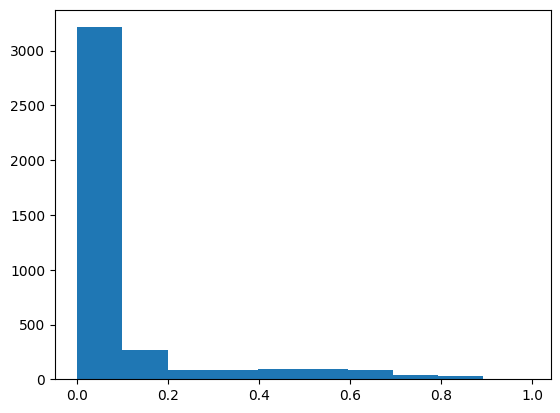

In [19]:
# distribution of risk
plt.hist(full[:,4]) 

This dataset demonstrates a strongly imbalanced outcome and class, similar to what we see in the Covid example. 

X0 is a boolean variable

X1 is a continuous value

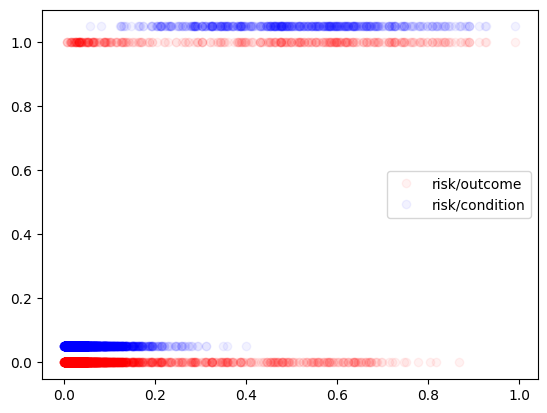

In [50]:
plt.plot(full[:,4], full[:,0], "ro", alpha=0.05, label="risk/outcome")
plt.plot(full[:,4], full[:,1]+0.05, "bo", alpha=0.05, label = "risk/condition")
plt.legend()

## Full Run

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.99929567)
[-2.09706734 -1.9044402 ]
[1.93038756 0.51756295]
[[1.78376772 0.44578416]
 [2.08113721 0.59183175]]


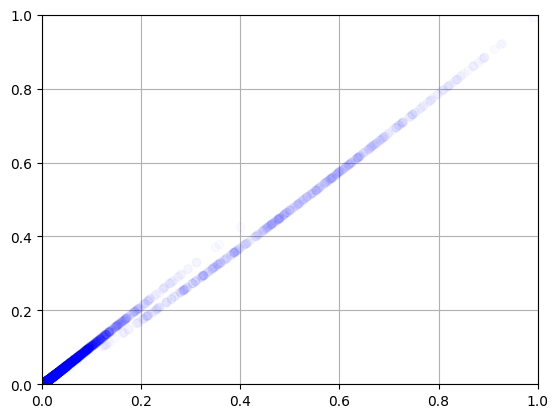

In [53]:
X = full[:,[1,2]]
Y = np.array(full[:,0]).flatten()
W = np.array(np.ones(full.shape[0])).flatten() # weights are all 1

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W)})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

# Plots
z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(full[:,4], mu1, "bo", alpha=0.02)
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

(0.0, 1.0, 0.0, 1.0)

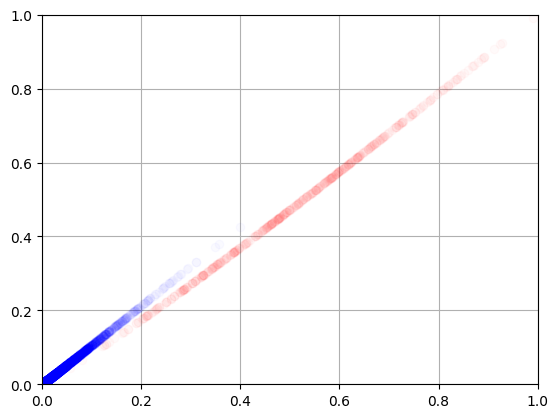

In [86]:
# sepearate on x0
cov_msk = np.array(full[:,1] == 1).flatten()
y_msk = np.array(full[:,0] == 1).flatten()

fig, ax = plt.subplots(1)
ax.plot(full[cov_msk,4], mu1[cov_msk], "ro", alpha=0.02)
ax.plot(full[~cov_msk,4], mu1[~cov_msk], "bo", alpha=0.02)
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


Retrun of alpha and Betas are appropriate.

We can see that there is a small negative bias in the Y=1 class. 

## Create a case-cohort dtst

In [111]:
np.random.seed(10)
PRCNT = .3
PRCNT_N = int(N*PRCNT)

# mask
case_msk = np.array(full[:,0]==1).reshape(full.shape[0],)
cntrl_msk = np.random.choice(N, size=PRCNT_N, replace=False)

# subset
case = full[case_msk,:]
cntrl = full[cntrl_msk,:]
chrt = np.vstack([case,cntrl])

#  chreate weights
wt_msk = np.array(chrt[:,0]==0).flatten()
wt = np.ones(chrt.shape[0])
wt[wt_msk] = 1/PRCNT
wt = wt.reshape(wt.shape[0],1)

# add weights to cohort
chrt = np.concatenate([chrt,wt],1)

In [114]:
y_msk = np.array(chrt[:,0] == 1).flatten()
x0_msk = np.array(chrt[:,1] == 1).flatten()

print(f"Cohort size: {chrt.shape}")
print(f"case N {case.shape}")
print(f"cntrl N {cntrl.shape}")
print(f"y=1 dist: {chrt[y_msk,0].shape}")
print(f"y=0 dist: {chrt[~y_msk,0].shape}")
print(f"x0=1 dist: {chrt[x0_msk,0].shape}")
print(f"x0=0 dist: {chrt[~x0_msk,0].shape}")

print(f"x0=1 and y=1 {chrt[(y_msk & x0_msk),:].shape}")
print(f"x0=0 and y=1 {chrt[(y_msk & ~x0_msk),:].shape}")


Cohort size: (1576, 6)
case N (376, 5)
cntrl N (1200, 5)
y=1 dist: (490, 1)
y=0 dist: (1086, 1)
x0=1 dist: (386, 1)
x0=0 dist: (1190, 1)
x0=1 and y=1 (313, 6)
x0=0 and y=1 (177, 6)


### Sample with weights

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.86992149)
[-1.96133622 -1.78525648]
[1.97261206 0.49978812]
[[1.83780163 0.43253034]
 [2.1180518  0.56735984]]


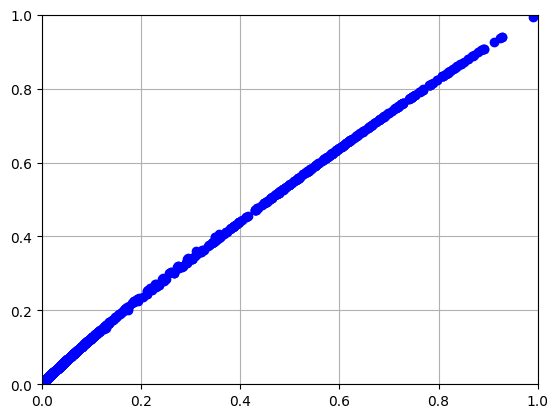

In [115]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
W = np.array(chrt[:,5]).flatten()
# W[W!=1] = W[W!=1]*1.2

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Returns good estimates, with a small bias on the the alpha parameter

The bias most likely is because of the minority ourcome (y=1) is actually overrepresented in the sample dataset

### Sample Run no weights

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.28261568)
[-1.39277541 -1.17678036]
[2.08993712 0.55197817]
[[1.89906672 0.46702965]
 [2.28078167 0.64018966]]


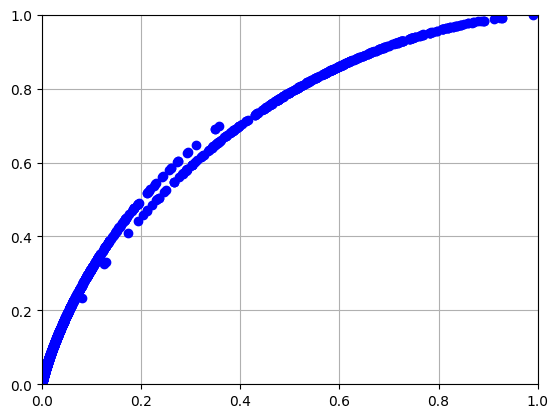

In [116]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
# W = np.array(chrt[:,5]).flatten()
# W[W!=1] = W[W!=1]*1.2
W = np.array(np.ones(chrt.shape[0])).flatten()


# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W)})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Heavily biased when the logp is not weighted. 

### Weights with a minor adjustment

In [135]:
cntl_y = (cntrl[:,0]==1).sum()
cntrl_sz = (cntrl.shape)
cntrl_x01 = cntrl[np.array(cntrl[:,1]==1).flatten(),:].shape[0]
cntrl_x00 = cntrl[np.array(cntrl[:,1]==0).flatten(),:].shape[0]
cntrl_x01_y1 = (cntrl[np.array(cntrl[:,1]==1).flatten(),:][:,0]==1).sum()
cntrl_x00_y1 = (cntrl[np.array(cntrl[:,1]==0).flatten(),:][:,0]==1).sum()

print(cntrl_x01/cntrl_x01_y1)
print(cntrl_x00/cntrl_x00_y1)


2.013888888888889
25.11904761904762


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.91119326)
[-2.00079864 -1.82528484]
[1.95848778 0.49448616]
[[1.81747872 0.4281643 ]
 [2.09777643 0.56187321]]


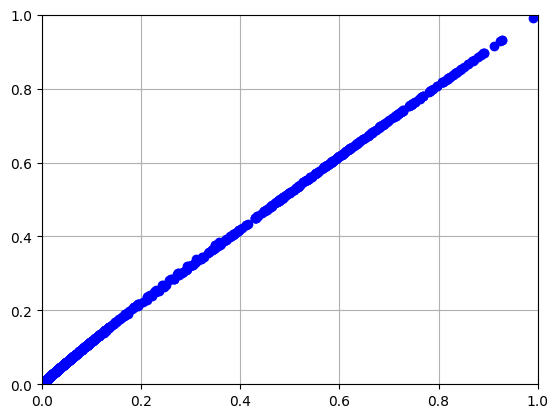

In [137]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
W = np.array(chrt[:,5]).flatten()
W[W!=1] = W[W!=1]*1.1 #################################### the 1.2 multiplier was found by trial/error

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Adjusting the logp weight to a slight increase returns the most accurate model. There is probably a systematic way to calculate these weights. I believe this would be in the relationship between number of Y==0 and Y==1. In this case-cohort sample the number of Y=1 is greater than Y=0 since Y=1 wasn't incredibly rare in the baseline cohort.

## Test how a random sample performs

In [138]:
smpl_msk = np.random.choice(full.shape[0], chrt.shape[0],replace=False)
smpl_chrt = full[smpl_msk,:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.9848525)
[-2.14300969 -1.83683258]
[1.8253593  0.52925745]
[[1.58747449 0.40889522]
 [2.06934048 0.64587756]]


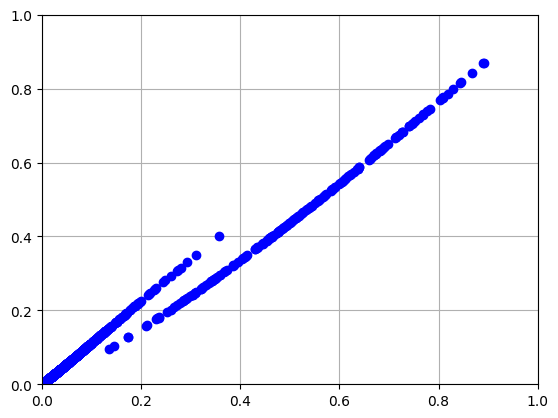

In [139]:
X = smpl_chrt[:,[1,2]]
Y = np.array(smpl_chrt[:,0]).flatten()
W = np.array(np.ones(smpl_chrt.shape[0])).flatten()


# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(smpl_chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

The sampel cohort of the same size as the case cohort return moderately okay results. The alpha param is more accurately returned, but the coefficients are worse

Notable is that the x0=1 group has less contributing values than in the previous models

# Case-Cohort with the PDP
- Train Model
    - Key things is beta shape parameter has to be hard coded otherwise the model will resample beta.
- Create PDP dataset
- Get posterior draws of PDP dataset
- Evaluate the plots


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [bern]


<xarray.DataArray 'alpha' ()>
array(-1.87095428)
[-1.95820162 -1.7834998 ]
[1.97490604 0.49971214]
[[1.83677435 0.4344693 ]
 [2.11799967 0.56785362]]


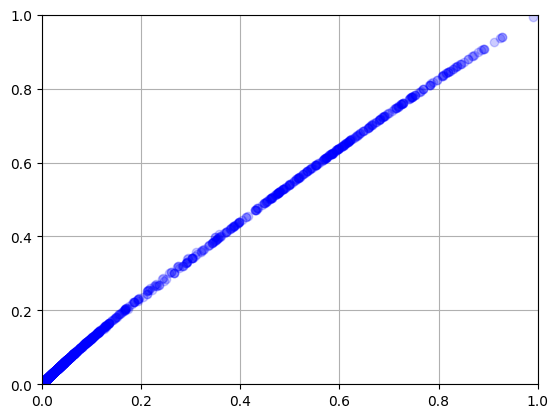

In [276]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
W = np.array(chrt[:,5]).flatten()
# W[W!=1] = W[W!=1]*1.2

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = 2)
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    bern = pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y, shape = x_data.shape[0])
    m11 = pm.sample(1000)
    
with model1:
    weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu", "bern"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo", alpha=0.2)
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

In [267]:
m11

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [219]:
# PDP dataset
x1_msk = np.array(chrt[:, 1] == 1).flatten()

chrt2 = np.vstack([chrt, chrt])


chrt2[:,1] = np.hstack([np.repeat(0, chrt.shape[0]), np.repeat(1, chrt.shape[0])]).reshape((chrt2.shape[0],1))

chrt2[:,3] = -2 + 2*chrt2[:,1] + .5*chrt2[:,2]
chrt2[:,4] = sp.norm.cdf(chrt2[:,3])

chrt3 = chrt.copy()
chrt3[:,1] = 1
chrt3[:,3] = -2 + 2*chrt3[:,1] + .5*chrt3[:,2]
chrt3[:,4] = sp.norm.cdf(chrt3[:,3])

In [288]:
# get new predictions on pdp dataset
with model1:
    x_data = pm.set_data({"x":chrt2[:,[1,2]]})
    pdp = pm.sample_posterior_predictive(m11, var_names=["mu","bern"])

Sampling: [bern]


In [307]:
pdp1  = pdp.posterior_predictive["mu"].values.mean((0,1))
s1 = chrt.shape[0]
tr_x00 = np.array(chrt2[:s1,4]).flatten()
tr_x01 = np.array(chrt2[s1:,4]).flatten()
te_x00 = pdp1[:s1]
te_x01 = pdp1[s1:]

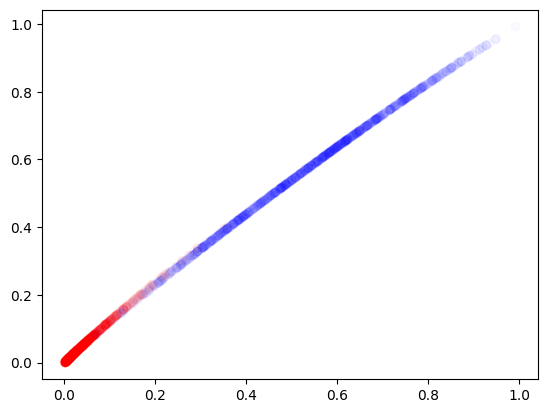

In [308]:
# Plot expected=predicted
plt.plot(tr_x00, te_x00, "ro", alpha=0.02)
plt.plot(tr_x01, te_x01, "bo", alpha=0.02)

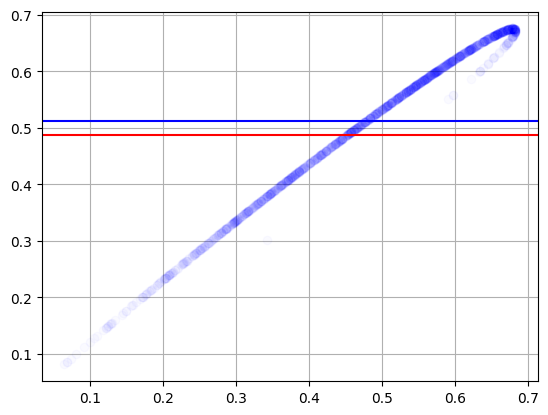

In [355]:
# plot expected difference vs pred difference on condition and mean values
plt.plot(tr_x01-tr_x00, te_x01-te_x00, "bo", alpha=0.02)
plt.axhline((tr_x01-tr_x00).mean(), color = "red")
plt.axhline((te_x01-te_x00).mean(), color = 'blue')
plt.grid(visible=True)

Based on th the average differences and exp=pred plots, we can determine the Case-Cohort with Weighted model does a good job identifying the marginal effect on the binary variable.